Training a neural network to predict $\delta C_9$ on an event-by-event basis (classification)

Import Libraries

In [ ]:
from pathlib import Path

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax, softmax, cross_entropy

from library.nn_training import train_and_eval, select_device
from library.plotting import setup_high_quality_mpl_params, plot_loss_curves
from library.datasets import Aggregated_Signal_Binned_Dataset, Bootstrapped_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

device = select_device()

# setup_high_quality_mpl_params()


Define Helper Functions

In [2]:
# def predict_set_likelihood(x, model):
#     """
#     Calculate sum_i log p(z | x_i)

#     x : torch tensor of events
#     model : torch model
#     """
#     model.eval()
#     with torch.no_grad():
#         logits = model(x)
#         pred = torch.sum(log_softmax(logits, dim=1), axis=0)
#     return pred


def predict_log_proba(x, model):
    """
    x is a set with a single label.
    """
    model.eval()
    with torch.no_grad():
        event_logits = model(x)
        event_log_probs = log_softmax(event_logits, dim=1)
        unnormalized_log_likelihoods = torch.sum(event_log_probs, dim=0)
        normalized_log_likelihoods = log_softmax(unnormalized_log_likelihoods, dim=0)
    return normalized_log_likelihoods


def predict_log_proba_bins(x, y, model):
    """
    x is an array of all events (many labels).
    y is labels of events.
    """
    bins = np.unique(y.cpu())
    preds = []
    for bin in bins:
        bin_x = x[y==bin]
        pred = predict_log_proba(bin_x, model).cpu().numpy()
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    assert preds.shape == (len(bins), len(bins))
    return preds


def predict_set_likelihood_ensemble(x, models):
    """
    Calculate sum_i log p(z | x_i) averaged over models

    x : torch tensor of events
    models : list of torch models
    """
    avg_ensemble_probs = predict_proba_ensemble(x, models)
    log_avg_ensemble_probs = torch.log(avg_ensemble_probs)
    likelihood = torch.sum(log_avg_ensemble_probs, dim=0)
    return likelihood


def predict_likelihood_over_bins_ensemble(x, y, models):
    """
    Calculate sum_i log p(z | x_i) for input sets from different bins.

    x : torch tensor of events
    y : torch tensor of bins
    model : torch model
    """
    assert len(x) == len(y)
    bins = np.unique(y.cpu())
    preds = []
    for bin in bins:
        bin_x = x[y==bin]
        pred = predict_set_likelihood_ensemble(bin_x, models).cpu().numpy()
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    assert preds.shape == (len(bins), len(bins))
    return preds


def predict_expected_value_over_bins_ensemble(x, y, models, bin_values):
    predicted_likelihoods = predict_likelihood_over_bins_ensemble(x, y, models)
    lse_predicted_likelihoods = logsumexp(predicted_likelihoods, axis=1)
    log_bin_values = np.tile(np.log(bin_values), (len(bin_values), 1))
    weighted_predicted_likelihoods = predicted_likelihoods + log_bin_values
    lse_weighted_predicted_likelihoods = logsumexp(weighted_predicted_likelihoods, axis=1)
    log_expected_value = lse_weighted_predicted_likelihoods - lse_predicted_likelihoods
    expected_value = np.exp(log_expected_value)
    return log_expected_value, expected_value


# def predict_likelihood_over_bootstrapped_trials(x, y, n_trials, n_events, model, device):
#     """
#     x : torch tensor of events
#     y : torch tensor of bins
#     n_trials : number of bootstrapped sample sets
#     n_events : number of events to bootstrap per sample set
#     """
#     x_np = x.cpu().numpy()
#     y_np = y.cpu().numpy()
#     pred_bins_over_trials = []
#     for _ in range(n_trials):
#         boot_x, boot_y = bootstrap_over_bins(x_np, y_np, n_events)
#         boot_x = torch.from_numpy(boot_x).to(device)
#         boot_y = torch.from_numpy(boot_y).to(device)
#         preds = predict_likelihood_over_bins(boot_x, boot_y, model)
#         pred_bins = np.argmax(preds, axis=1)
#         pred_bins_over_trials.append(np.expand_dims(pred_bins, axis=0))
#     pred_bins_over_trials = np.concatenate(pred_bins_over_trials)
#     return pred_bins_over_trials


def plot_likelihood_over_bins(fig, ax, predictions, bin_values, cmap=plt.cm.viridis):
    """
    predictions_over_bins : ndarray of summed log event probabilities
        (rows are input bins, columns are bin predictions)
    bin_values : ndarray of the value each bin represents 
    """

    bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for value, curve in zip(bin_values, predictions):
        ax.plot(bin_values, curve, color=cmap(norm(value)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r"$\delta C_9$")
    ax.set_xlabel(r"$\delta C_9$")
    ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")



def plot_expected_value_over_bins(expected_values, bin_values):
    plt.scatter(bin_values, expected_values)
    plt.plot(bin_values, bin_values)
    plt.show()



Define Model

In [4]:
class Event_By_Event_NN(nn.Module):
    def __init__(self, nickname):
        super().__init__()

        self.nickname = nickname
        model_dir = Path("../../state/new_physics/models")
        self.save_path = model_dir.joinpath(f"{nickname}.pt")

        self.base = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 44),
         )
        
        self.double()

    def forward(self, x):
        result = self.base(x)
        return result
    


Load / Generate Datasets

In [ ]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

normalize = True
q_squared_veto = True

datasets = {
    "train": Aggregated_Signal_Binned_Dataset(level=level, split="train", raw_trials=range(1,5), save_dir=save_dir),
    "eval": Aggregated_Signal_Binned_Dataset(level=level, split="eval", raw_trials=range(5,10), save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(raw_signal_dir, std_scale=normalize, q_squared_veto=q_squared_veto)
    datasets["eval"].generate(raw_signal_dir, std_scale=normalize, q_squared_veto=q_squared_veto)

datasets["train"].load(device)
datasets["eval"].load(device)

np.testing.assert_equal(datasets["train"].bin_values, datasets["eval"].bin_values)

Train / Load Model

In [ ]:
retrain = True

model = Event_By_Event_NN("ebe")

def my_loss(yhat, y):
    set_dim = 1
    y = y.repeat(yhat.shape[set_dim], 1).T
    y = y.flatten()
    yhat = yhat.flatten(end_dim=set_dim)
    loss = cross_entropy(yhat, y)
    return loss

if retrain:
    learning_rate = 4e-2
    epochs = 10000
    train_batch_size = 10000
    eval_batch_size = len(datasets["eval"].labels)
    loss_fn = my_loss
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler= ReduceLROnPlateau(optimizer, factor=0.9)

    )
    torch.save(model.state_dict(), model.save_path)
    _, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
    plt.show()
else:
    model.load_state_dict(torch.load(model.save_path, weights_only=True))
    model.to(device)

Evaluate Model

In [ ]:
fig, ax = plt.subplots(layout="constrained")

probs = predict_log_proba_bins(datasets["eval"].features, datasets["eval"].labels, model)
plot_likelihood_over_bins(fig, ax, probs, datasets["eval"].bin_values)

In [ ]:

preds = predict_likelihood_over_bins_ensemble(
    source_datasets["eval"].features.to(device), source_datasets["eval"].labels.to(device), models[0:1])

plot_likelihood_over_bins(preds, source_datasets["eval"].bin_values)

In [ ]:
bin_values = np.linspace(1, 5, 44)

_, expected_values = predict_expected_value_over_bins_ensemble(source_datasets["train"].features.to(device), source_datasets["train"].labels.to(device), models[0:50], bin_values)

plot_expected_value_over_bins(expected_values, bin_values)

In [ ]:
bin_values = np.linspace(1, 5, 44)

_, expected_values = predict_expected_value_over_bins_ensemble(source_datasets["eval"].features.to(device), source_datasets["eval"].labels.to(device), models[0:50], bin_values)

plot_expected_value_over_bins(expected_values, bin_values)

In [ ]:
boot_x, boot_y = bootstrap_over_bins(
    train_dataset.feat.cpu(), train_dataset.labels.cpu(), 24_000)

preds = predict_likelihood_over_bins(
    torch.from_numpy(boot_x).to(device), torch.from_numpy(boot_y).to(device), model)

plot_likelihood_over_bins(preds, eval_dataset.bin_values)

In [ ]:
pred_bins_over_trials = predict_likelihood_over_bootstrapped_trials(
    eval_dataset.feat, 
    eval_dataset.labels, 
    n_trials=10,
    n_events=24_000,
    model=model,
    device=device    
)

pred_values_over_trials = eval_dataset.bin_values[pred_bins_over_trials]
avg_pred_values_over_trials = np.mean(pred_values_over_trials, axis=0)
stdev_pred_values_over_trials = np.std(pred_values_over_trials, axis=0)

plot_prediction_linearity(
    eval_dataset.bin_values,
    avg_pred_values_over_trials,
    stdev_pred_values_over_trials,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)


In [ ]:
pred_bins_over_trials = predict_likelihood_over_bootstrapped_trials(
    train_dataset.feat, 
    train_dataset.labels, 
    n_trials=10,
    n_events=24_000,
    model=model,
    device=device    
)

pred_values_over_trials = eval_dataset.bin_values[pred_bins_over_trials]
avg_pred_values_over_trials = np.mean(pred_values_over_trials, axis=0)
stdev_pred_values_over_trials = np.std(pred_values_over_trials, axis=0)

plot_prediction_linearity(
    eval_dataset.bin_values,
    avg_pred_values_over_trials,
    stdev_pred_values_over_trials,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)

In [ ]:
l = MSELoss() 
l(model.layers[6].weight, torch.zeros_like(model.layers[6].weight))

In [1]:
from pathlib import Path

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax, softmax, cross_entropy

from library.nn_training import train_and_eval, select_device
from library.plotting import setup_high_quality_mpl_params, plot_loss_curves
from library.datasets import Aggregated_Signal_Binned_Dataset, Bootstrapped_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

device = select_device()

# setup_high_quality_mpl_params()


Device:  cuda


In [2]:
class Event_By_Event_NN(nn.Module):
    def __init__(self, nickname):
        super().__init__()

        self.nickname = nickname
        model_dir = Path("../../state/new_physics/models")
        self.save_path = model_dir.joinpath(f"{nickname}.pt")

        self.base = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 44),
         )
        
        self.double()

    def forward(self, x):
        result = self.base(x)
        return result
    


In [3]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

num_events_per_set = 24_000
num_sets_per_label = 2

normalize = True
q_squared_veto = True

datasets = {
    "train": Bootstrapped_Signal_Binned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Bootstrapped_Signal_Binned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(0,5), 
        raw_signal_dir=raw_signal_dir, 
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        std_scale=normalize, 
        q_squared_veto=q_squared_veto,
    )
    datasets["eval"].generate(
        raw_trials=range(0,5), 
        raw_signal_dir=raw_signal_dir, 
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        std_scale=normalize, 
        q_squared_veto=q_squared_veto,
    )

datasets["train"].load(device)
datasets["eval"].load(device)

np.testing.assert_equal(datasets["train"].bin_values, datasets["eval"].bin_values)

Loaded data with features size: torch.Size([88, 24000, 4]) and labels size: torch.Size([88]).
Loaded data with features size: torch.Size([88, 24000, 4]) and labels size: torch.Size([88]).


In [4]:
# datasets["train"].labels = datasets["train"].labels.repeat(datasets["train"].features.shape[1], 1).T
# datasets["eval"].labels = datasets["eval"].labels.repeat(datasets["eval"].features.shape[1], 1).T


epoch 0 complete:
    Train loss: 3.7964137114208425
    Eval loss: 3.7957490818036144

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 1 complete:
    Train loss: 3.7959234036081773
    Eval loss: 3.7955623598765165

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 2 complete:
    Train loss: 3.7956376352805403
    Eval loss: 3.795397727532482

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 3 complete:
    Train loss: 3.7955101578723713
    Eval loss: 3.7952392902856396

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 4 complete:
    Train loss: 3.7952954921588873
    Eval loss: 3.7950945125835935

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 5 complete:
    Train loss: 3.7951470780357406
    Eval loss: 3.7949638546623508

learning rate: [0.0003]
peak gpu memory usage: 1.94372 GB

epoch 6 complete:
    Train loss: 3.795006214475398
    Eval loss: 3.794835233154269

learning rate: [0.0003]
peak gpu

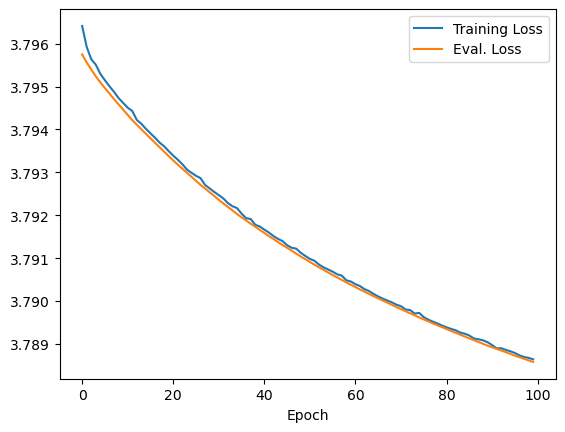

In [15]:
retrain = True

model = Event_By_Event_NN("ebe")


if retrain:
    learning_rate = 3e-4
    epochs = 100
    train_batch_size = 44
    eval_batch_size = 44
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler= ReduceLROnPlateau(optimizer, factor=0.95),

    )
    torch.save(model.state_dict(), model.save_path)
    _, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
    plt.show()
else:
    model.load_state_dict(torch.load(model.save_path, weights_only=True))
    model.to(device)

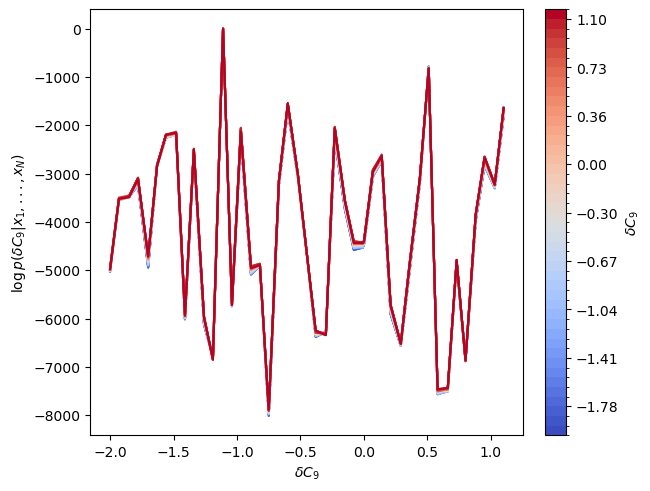

In [16]:
def predict_log_proba(x, model):
    """
    x is a set with a single label.
    """
    model.eval()
    with torch.no_grad():
        event_logits = model(x)
        event_log_probs = log_softmax(event_logits, dim=1)
        unnormalized_log_likelihoods = torch.sum(event_log_probs, dim=0)
        normalized_log_likelihoods = log_softmax(unnormalized_log_likelihoods, dim=0)
    return normalized_log_likelihoods


def predict_log_proba_bins(x, model):
    """
    x is an array of all events (many labels).
    y is labels of events.
    """
    preds = []
    for set_x in x:
        pred = predict_log_proba(set_x, model).cpu().numpy()
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    # assert preds.shape == (len(bins), len(bins))
    return preds


def plot_likelihood_over_bins(fig, ax, predictions, bin_values, cmap=plt.cm.coolwarm):
    """
    predictions_over_bins : ndarray of summed log event probabilities
        (rows are input bins, columns are bin predictions)
    bin_values : ndarray of the value each bin represents 
    """

    bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for value, curve in zip(bin_values, predictions):
        ax.plot(bin_values, curve, color=cmap(norm(value)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r"$\delta C_9$")
    ax.set_xlabel(r"$\delta C_9$")
    ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")


fig, ax = plt.subplots(layout="constrained")

probs = predict_log_proba_bins(datasets["eval"].features, model)
plot_likelihood_over_bins(fig, ax, probs, datasets["eval"].bin_values)